In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
# Read the CSV file
ball_df = pd.read_csv('../data/raw/ball_positions.csv')
print(ball_df.columns)

Index(['Frame', ' ball_x', ' ball_y'], dtype='object')


In [4]:
# Strip leading/trailing spaces from column names
ball_df.columns = ball_df.columns.str.strip()

# Debugging: Print the cleaned column names
print("Cleaned Columns:", ball_df.columns)

# Interpolate missing X and Y values
ball_df[['ball_x', 'ball_y']] = ball_df[['ball_x', 'ball_y']].interpolate(limit_direction='both')

# Drop rows where X or Y are still NaN
ball_df = ball_df.dropna(subset=['ball_x', 'ball_y'])

# Convert X and Y to float32
ball_df[['ball_x', 'ball_y']] = ball_df[['ball_x', 'ball_y']].astype('float32')

# Check result
print("After interpolation:")
print(ball_df.head(150))

# Save cleaned version (optional)
ball_df.to_csv("../data/results/ball_positions_interpolated.csv", index=False)

Cleaned Columns: Index(['Frame', 'ball_x', 'ball_y'], dtype='object')
After interpolation:
    Frame       ball_x      ball_y
0       0  1624.500000  492.000000
1       1  1655.000000  496.000000
2       2  1540.000000  392.500000
3       3  1538.000000  393.500000
4       4  1539.500000  387.500000
..    ...          ...         ...
74     74   292.666656  600.444458
75     75   208.333328  564.722229
76     76   124.000000  529.000000
77     77   106.500000  507.500000
78     78    90.000000  487.000000

[79 rows x 3 columns]


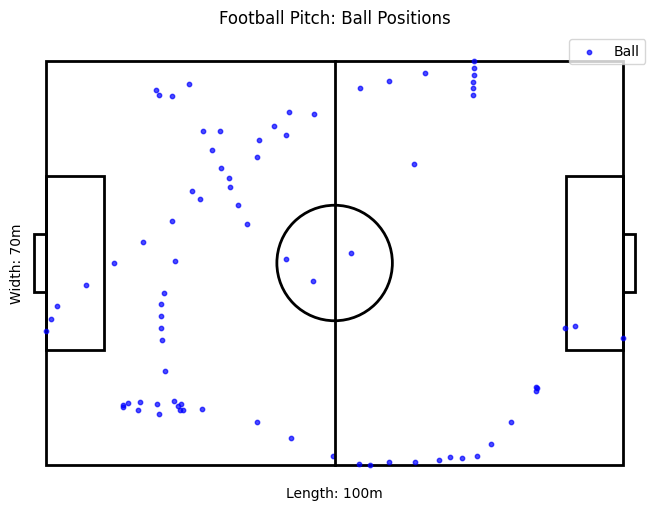

In [5]:
# Load the interpolated ball positions
ball_df = pd.read_csv("../data/results/ball_positions_interpolated.csv")

# Function to draw the football pitch
def draw_pitch(ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Pitch Outline
    pitch = patches.Rectangle([0, 0], 1, 0.7, edgecolor="black", facecolor="none", lw=2)
    ax.add_patch(pitch)
    
    # Center Circle
    center_circle = patches.Circle([0.5, 0.35], 0.1, edgecolor="black", facecolor="none", lw=2)
    ax.add_patch(center_circle)
    
    # Halfway Line
    ax.plot([0.5, 0.5], [0, 0.7], color="black", lw=2)
    
    # Penalty Areas
    penalty_area_left = patches.Rectangle([0, 0.2], 0.1, 0.3, edgecolor="black", facecolor="none", lw=2)
    penalty_area_right = patches.Rectangle([0.9, 0.2], 0.1, 0.3, edgecolor="black", facecolor="none", lw=2)
    ax.add_patch(penalty_area_left)
    ax.add_patch(penalty_area_right)
    
    # Goals
    goal_left = patches.Rectangle([-0.02, 0.3], 0.02, 0.1, edgecolor="black", facecolor="none", lw=2)
    goal_right = patches.Rectangle([1, 0.3], 0.02, 0.1, edgecolor="black", facecolor="none", lw=2)
    ax.add_patch(goal_left)
    ax.add_patch(goal_right)
    
    # Add field dimensions as labels
    ax.text(0.5, -0.05, "Length: 100m", ha="center", va="center", fontsize=10, color="black")
    ax.text(-0.05, 0.35, "Width: 70m", ha="center", va="center", fontsize=10, color="black", rotation=90)
        
    # Set limits and aspect
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 0.75)
    ax.set_aspect("equal")
    ax.axis("off")
    return ax

# Normalize positions to fit within the pitch dimensions
ball_df["pitch_ball_x"] = (ball_df["ball_x"] - ball_df["ball_x"].min()) / (ball_df["ball_x"].max() - ball_df["ball_x"].min())
ball_df["pitch_ball_y"] = (ball_df["ball_y"] - ball_df["ball_y"].min()) / (ball_df["ball_y"].max() - ball_df["ball_y"].min()) * 0.7

# Plot the football pitch and positions
ax = draw_pitch()
ax.scatter(ball_df["pitch_ball_x"], ball_df["pitch_ball_y"], color="blue", label="Ball", alpha=0.7, s=10)

# Add legend and title
ax.legend(loc="upper right")
ax.set_title("Football Pitch: Ball Positions")

plt.show()